In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/windows-malwares/PE_Section.csv
/kaggle/input/windows-malwares/DLLs_Imported.csv
/kaggle/input/windows-malwares/API_Functions.csv
/kaggle/input/windows-malwares/PE_Header.csv


In [2]:
# !pip uninstall -y sklearn

# !pip install --no-cache-dir --force-reinstall \
#     numpy==1.26.4 scipy==1.13.0 scikit-learn==1.5.2


In [3]:
!pip uninstall -y scikit-learn sklearn imbalanced-learn
!pip install --no-cache-dir --force-reinstall \
  "scikit-learn==1.7.2" "imbalanced-learn==0.14.0" \
  "numpy==1.26.4" "scipy==1.13.0"


Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 141.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 210.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 217.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 204.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 256.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 256.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 171.4 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successf

In [4]:
# Install a sklearn version that provides UnsetMetadataPassedError
# # and keep numpy/scipy compatible to avoid binary mismatches.
# !pip install --no-cache-dir --force-reinstall \
#     "scikit-learn>=1.5,<1.7" "numpy<2.0" "scipy>=1.11,<1.13"


# Data Engineering

In [5]:
# Paths to the four CSVs from above
p_dlls   = "/kaggle/input/windows-malwares/DLLs_Imported.csv"
p_api    = "/kaggle/input/windows-malwares/API_Functions.csv"
p_hdr    = "/kaggle/input/windows-malwares/PE_Header.csv"
p_sect   = "/kaggle/input/windows-malwares/PE_Section.csv"

## Check Binary/Continuous Features for Each Dataset

In [6]:
# Helper: read CSV and lower-case/normalize column names
def read_norm(path):
    df = pd.read_csv(path, low_memory=False)
    df.columns = [c.strip().lower() for c in df.columns]
    return df

dlls  = read_norm(p_dlls)
api   = read_norm(p_api)
hdr   = read_norm(p_hdr)
sect  = read_norm(p_sect)

In [7]:
# dlls.dtypes

In [8]:
def column_type_summary(df, name):
    binary_cols = []
    continuous_cols = []

    for col in df.columns:
        if col.lower() in ['sha256', 'type']:
            continue
        vals = df[col].dropna().unique()
        if set(vals).issubset({0, 1}):
            binary_cols.append(col)
        else:
            continuous_cols.append(col)

    print(f"--- {name} ---")
    print(f"Rows:               {len(df):>7,}")
    print(f"Binary columns:     {len(binary_cols):>7}")
    print(f"Continuous columns: {len(continuous_cols):>7}")
    print(f"Total feature cols: {len(df.columns) - 2:>7}")  # excluding sha256 + type
    print(f"Total columns:      {len(df.columns):>7}\n")

    return binary_cols, continuous_cols

# Binary Datasets
dlls_bin, dlls_cont = column_type_summary(dlls, "p_dlls")
api_bin, api_cont   = column_type_summary(api,  "p_api")

# Continuous Datasets
hdr_bin, hdr_cont   = column_type_summary(hdr,  "p_hdr")
sect_bin, sect_cont = column_type_summary(sect, "p_sect")


--- p_dlls ---
Rows:                29,498
Binary columns:         629
Continuous columns:       0
Total feature cols:     629
Total columns:          631

--- p_api ---
Rows:                29,505
Binary columns:       21918
Continuous columns:       0
Total feature cols:   21918
Total columns:        21920

--- p_hdr ---
Rows:                29,807
Binary columns:           1
Continuous columns:      51
Total feature cols:      52
Total columns:           54

--- p_sect ---
Rows:                29,760
Binary columns:           8
Continuous columns:      82
Total feature cols:      90
Total columns:           92



## Merge Respective Binary/Continuous Datasets (Binary: APIs + DLLs | Continuous: PE_Header + PE_Sections)

In [9]:
# Ensure the join key is present and normalized
for df in [dlls, api, hdr, sect]:
    assert 'sha256' in df.columns, f"'sha256' not found in {df.shape}"

# (Optional) cast 0/1 feature columns to smaller ints to save RAM
def cast_binary(df):
    for c in df.columns:
        if c not in ('sha256', 'type'):
            # Try to downcast to uint8 if it looks like binary
            if df[c].dropna().isin([0,1]).all():
                df[c] = df[c].astype('uint8')
    return df

dlls = cast_binary(dlls)
api  = cast_binary(api)
# hdr/sect are numeric counts/sizes; let pandas infer first (or downcast later)

In [10]:
from functools import reduce

# Keep 'type' only once; check for mismatches first.
def label_map(df):
    return df[['sha256', 'type']].drop_duplicates()

### Binary: (APIs + DLLs)

In [11]:
lbls = [label_map(x).rename(columns={'type': f"type_{i}"}) for i, x in enumerate([dlls, api])]
lbl_chk = reduce(lambda l, r: l.merge(r, on='sha256', how='outer'), lbls)

# If all labels match per sha256, each row should have identical values across type_* columns
mismatch = lbl_chk.drop(columns=['sha256']).nunique(axis=1) > 1
print("Label mismatches:", mismatch.sum())
# If mismatches==0, we can safely keep one 'type' column later.

Label mismatches: 0


In [12]:
binary_df = dlls.merge(api, on=['sha256', 'type'], how='inner')

# drop duplicate columns
dupe_cols = [c for c in binary_df.columns if c.startswith('type') and c != 'type']
binary_df.drop(columns=dupe_cols, inplace=True, errors='ignore')

print(binary_df.shape)

(29502, 22533)


In [13]:
binary_df.head()

,sha256,type,advapi32.dll,kernel32.dll,vspmsg.dll,ole32.dll,oleaut32.dll,psapi.dll,setupapi.dll,shlwapi.dll,...,drawdibclose,ord1107,wsasetblockinghook,setupinstallfileexa,setupterminatefilelog,setuplogfilew,setupopenmasterinf,setupinstallfileexw,setupgetlinecountw,setupdigethwprofilefriendlynameexw
0,002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2a053f32b1d48539e3e2807f86754be87ce95b08378467...,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2f031a1752f7067fb9f483ae0ac5f3036c9b66cc4af40e...,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,308e8bb2e8a3b67607d2454370e0b50147b42049bda813...,0,1,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,31aaba443b9869e6e68c17125f8d7989cbd762fb38ae3a...,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Continuous: (PE Header + PE Sections)

In [14]:
lbls = [label_map(x).rename(columns={'type': f"type_{i}"}) for i, x in enumerate([hdr, sect])]
lbl_chk = reduce(lambda l, r: l.merge(r, on='sha256', how='outer'), lbls)

# If all labels match per sha256, each row should have identical values across type_* columns
mismatch = lbl_chk.drop(columns=['sha256']).nunique(axis=1) > 1
print("Label mismatches:", mismatch.sum())
# If mismatches==0, we can safely keep one 'type' column later.

Label mismatches: 0


In [15]:
cont_df = hdr.merge(sect, on=['sha256', 'type'], how='inner')

# drop duplicate columns
dupe_cols = [c for c in cont_df.columns if c.startswith('type') and c != 'type']
cont_df.drop(columns=dupe_cols, inplace=True, errors='ignore')

print(cont_df.shape)

(29514, 144)


In [16]:
cont_df.head()

,sha256,type,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,...,tls_characteristics,pdata_misc_virtualsize,pdata_virtualaddress,pdata_sizeofrawdata,pdata_pointertorawdata,pdata_pointertorelocations,pdata_pointertolinenumbers,pdata_numberofrelocations,pdata_numberoflinenumbers,pdata_characteristics
0,dacbe8cb72dd746539792a50e84965fefef73feaa07b5d...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
1,d3dc7512ce75db33b2c3063fa99245e9ca9fe3b086462f...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
2,b350fac81533f02981dc2176ed17163177d92d9405758e...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
3,dfee618043a47b7b09305df0ca460559d9f567ee246c7b...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
4,c7b2e4e4fb2fcc44c953673ff57c3d14bdf5d2008f35e9...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0


#### Old Merged Dataset (All 4)

In [17]:
# lbls = [label_map(x).rename(columns={'type': f"type_{i}"}) for i, x in enumerate([dlls, api, hdr, sect])]
# lbl_chk = reduce(lambda l, r: l.merge(r, on='sha256', how='outer'), lbls)

# # If all labels match per sha256, each row should have identical values across type_* columns
# mismatch = lbl_chk.drop(columns=['sha256']).nunique(axis=1) > 1
# print("Label mismatches:", mismatch.sum())
# # If mismatches==0, we can safely keep one 'type' column later.

In [18]:
# # Inner join across all four
# merged = dlls.merge(api,  on='sha256', suffixes=('', '_api'))
# merged = merged.merge(hdr,  on='sha256', suffixes=('', '_hdr'))
# merged = merged.merge(sect, on='sha256', suffixes=('', '_sect'))

# # Keep a single label column: prefer the one from dlls, drop duplicates
# for col in [c for c in merged.columns if c.startswith('type') and c != 'type']:
#     merged.drop(columns=col, inplace=True, errors='ignore')

# print(merged.shape)  # rows × columns (API_Functions alone has ~21,9k cols)


## Null/Missing Values

In [19]:
missing_counts = binary_df.isnull().sum()

missing = missing_counts[missing_counts > 0].sort_values(ascending=False)
print("Columns with missing values:")
print(missing)

total_cells = binary_df.size
total_missing = missing_counts.sum()
percent_missing = (total_missing / total_cells) * 100
print(f"\nTotal missing values: {total_missing:,} ({percent_missing:.2f}%)")
print(f"Columns with missing data: {len(missing)} of {binary_df.shape[1]}")


Columns with missing values:
Series([], dtype: int64)

Total missing values: 0 (0.00%)
Columns with missing data: 0 of 22533


In [20]:
missing_counts = cont_df.isnull().sum()

missing = missing_counts[missing_counts > 0].sort_values(ascending=False)
print("Columns with missing values:")
print(missing)

total_cells = cont_df.size
total_missing = missing_counts.sum()
percent_missing = (total_missing / total_cells) * 100
print(f"\nTotal missing values: {total_missing:,} ({percent_missing:.2f}%)")
print(f"Columns with missing data: {len(missing)} of {cont_df.shape[1]}")


Columns with missing values:
Series([], dtype: int64)

Total missing values: 0 (0.00%)
Columns with missing data: 0 of 144


## Outlier Detection

In [21]:
df = cont_df.drop(columns=['sha256'])

In [22]:
# Identify binary columns (values only 0/1)
binary_cols = [c for c in df.columns if set(pd.unique(df[c].dropna())) <= {0, 1}]
continuous_cols = [c for c in df.columns if c not in binary_cols]

print("Binary columns:", len(binary_cols))
print("Continuous columns:", len(continuous_cols))


Binary columns: 9
Continuous columns: 134


In [23]:
Q1 = cont_df[continuous_cols].quantile(0.25)
Q3 = cont_df[continuous_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outliers: outside 1.5×IQR
outlier_mask = ((cont_df[continuous_cols] < (Q1 - 1.5 * IQR)) |
                (cont_df[continuous_cols] > (Q3 + 1.5 * IQR)))


Outlier counts per column:
 timedatestamp            7233
data_misc_virtualsize    6648
text_pointertorawdata    5986
sizeofheaders            5941
filealignment            5839
                         ... 
e_magic                     0
data_characteristics        0
dllcharacteristics          0
sectionalignment            0
type                        0
Length: 134, dtype: int64


NameError: name 'outlier_score' is not defined

In [24]:
# 'outlier_score' counts how many continuous features are outliers in each row
outlier_score = outlier_mask.sum(axis=1)

# Basic descriptive stats
print(outlier_score.describe())


count    29514.000000
mean         5.568374
std          6.825756
min          0.000000
25%          1.000000
50%          4.000000
75%          7.000000
max         57.000000
dtype: float64


In [25]:
# Count outliers per column
outlier_counts = outlier_mask.sum().sort_values(ascending=False)
print("Outlier counts per column:\n", outlier_counts)

# Fraction of rows that have at least one outlier feature
rows_with_outlier = (outlier_score > 0).mean() * 100
print(f"Rows with ≥1 outlier: {rows_with_outlier:.2f}%")

# Fraction of rows with "many" outliers, e.g., >20
rows_with_many_outliers = (outlier_score > 20).mean() * 100
print(f"Rows with >20 outliers: {rows_with_many_outliers:.2f}%")

Outlier counts per column:
 timedatestamp            7233
data_misc_virtualsize    6648
text_pointertorawdata    5986
sizeofheaders            5941
filealignment            5839
                         ... 
e_magic                     0
data_characteristics        0
dllcharacteristics          0
sectionalignment            0
type                        0
Length: 134, dtype: int64
Rows with ≥1 outlier: 78.42%
Rows with >20 outliers: 5.10%


In [28]:
# See the rows with the most outliers
top_outliers = cont_df.loc[outlier_score.head(10).index]
display(top_outliers)

# Quick summary
print(f"Max outlier count in one row: {outlier_score.max()} / {len(continuous_cols)}")


,sha256,type,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,...,tls_characteristics,pdata_misc_virtualsize,pdata_virtualaddress,pdata_sizeofrawdata,pdata_pointertorawdata,pdata_pointertorelocations,pdata_pointertolinenumbers,pdata_numberofrelocations,pdata_numberoflinenumbers,pdata_characteristics
0,dacbe8cb72dd746539792a50e84965fefef73feaa07b5d...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
1,d3dc7512ce75db33b2c3063fa99245e9ca9fe3b086462f...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
2,b350fac81533f02981dc2176ed17163177d92d9405758e...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
3,dfee618043a47b7b09305df0ca460559d9f567ee246c7b...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
4,c7b2e4e4fb2fcc44c953673ff57c3d14bdf5d2008f35e9...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
5,a36878ce723af818246c98ad08e38b83686c7e9267f244...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
6,c8deef6eb5744a1fed083051d7bf4a699c5880ee13f343...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
7,d3e4d6dd3e427229e5c8fd2409dbef6d28356a163ead6e...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
8,afbae9a4b2e4c0e04dc7f7b5c8eba539bcaea91363a544...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0
9,86e32ca260ea85c252d7d0d7bf06034f4fa4ada3db583d...,0,23117,144,3,0,4,0,65535,0,...,0,0,0,0,0,0,0,0,0,0


Max outlier count in one row: 57 / 134


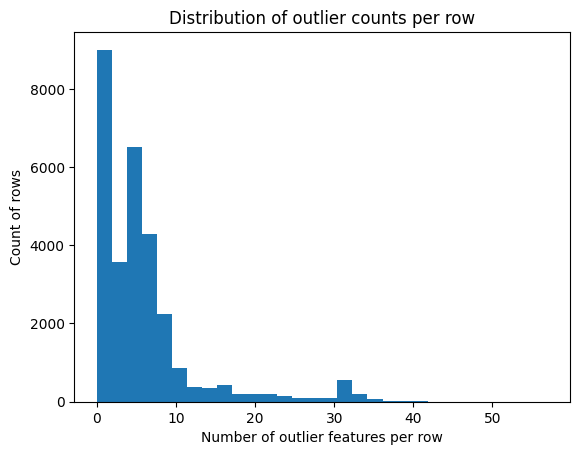

In [29]:
import matplotlib.pyplot as plt

plt.hist(outlier_score, bins=30)
plt.xlabel("Number of outlier features per row")
plt.ylabel("Count of rows")
plt.title("Distribution of outlier counts per row")
plt.show()


In [ ]:
# threshold = 30  # e.g., more than 30 outlier features
# extreme_rows = outlier_score[outlier_score > threshold].index
# print(f"Removing {len(extreme_rows)} rows with >{threshold} outliers")

# clean_df = cont_df.drop(index=extreme_rows)


## Check Target Variable

In [30]:
print(binary_df['type'].value_counts())
print(cont_df['type'].value_counts())

type
4    5076
1    5022
3    4957
2    4643
5    4228
6    3699
0    1877
Name: count, dtype: int64
type
4    5090
1    5022
3    4955
2    4643
5    4228
6    3699
0    1877
Name: count, dtype: int64


## Feature Engineering Type into Binary (Yes/No Malware)

In [31]:
binary_df['type'] = binary_df['type'].apply(lambda x: 0 if x == 0 else 1)
cont_df['type'] = cont_df['type'].apply(lambda x: 0 if x == 0 else 1)

In [32]:
print(binary_df['type'].value_counts())

type
1    27625
0     1877
Name: count, dtype: int64


In [33]:
print(cont_df['type'].value_counts())

type
1    27637
0     1877
Name: count, dtype: int64


## Save Datasets

In [34]:
binary_df.to_csv("/kaggle/working/binary_df.csv", index=False)

In [35]:
cont_df.to_csv("/kaggle/working/cont_df.csv", index=False)

In [36]:
binary_df.describe()

,type,advapi32.dll,kernel32.dll,vspmsg.dll,ole32.dll,oleaut32.dll,psapi.dll,setupapi.dll,shlwapi.dll,pdh.dll,...,drawdibclose,ord1107,wsasetblockinghook,setupinstallfileexa,setupterminatefilelog,setuplogfilew,setupopenmasterinf,setupinstallfileexw,setupgetlinecountw,setupdigethwprofilefriendlynameexw
count,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000,...,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000,29502.000000
mean,0.936377,0.224561,0.494882,0.000068,0.105145,0.105823,0.009660,0.002034,0.045488,0.001186,...,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034,0.000034
std,0.244084,0.417300,0.499982,0.008233,0.306746,0.307617,0.097813,0.045052,0.208376,0.034424,...,0.005822,0.005822,0.005822,0.005822,0.005822,0.005822,0.005822,0.005822,0.005822,0.005822
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
cont_df.describe()

,type,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,...,tls_characteristics,pdata_misc_virtualsize,pdata_virtualaddress,pdata_sizeofrawdata,pdata_pointertorawdata,pdata_pointertorelocations,pdata_pointertolinenumbers,pdata_numberofrelocations,pdata_numberoflinenumbers,pdata_characteristics
count,29514.000000,29514.0,29514.000000,29514.000000,29514.000000,29514.000000,29514.000000,29514.000000,29514.000000,29514.000000,...,2.951400e+04,2.951400e+04,2.951400e+04,29514.000000,2.951400e+04,29514.0,29514.0,29514.0,29514.0,2.951400e+04
mean,0.936403,23117.0,252.057600,760.630582,407.165616,43.952497,357.971878,64783.064444,200.951108,379.993427,...,1.267949e+08,3.662612e+02,4.230202e+03,126.791489,3.733520e+03,0.0,0.0,0.0,0.0,2.426164e+07
std,0.244038,0.0,1533.323156,6614.329221,3655.715173,1296.182554,3135.663135,6446.579253,1819.260481,2336.188709,...,6.268681e+08,2.019475e+04,9.086047e+04,3550.433931,8.813059e+04,0.0,0.0,0.0,0.0,1.710697e+08
min,0.000000,23117.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00
25%,1.000000,23117.0,144.000000,3.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00
50%,1.000000,23117.0,144.000000,3.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00
75%,1.000000,23117.0,144.000000,3.000000,0.000000,4.000000,0.000000,65535.000000,0.000000,184.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00
max,1.000000,23117.0,64110.000000,62388.000000,63030.000000,64913.000000,57879.000000,65535.000000,59756.000000,64539.000000,...,3.758096e+09,3.284992e+06,7.737344e+06,509025.000000,7.721984e+06,0.0,0.0,0.0,0.0,3.758096e+09


In [ ]:
# 1) Split features/labels
X = binary_df.drop(columns=['sha256', 'type'])
y = binary_df['type']

# 2) Train/test split with stratification (avoid leakage)
from sklearn.model_selection import train_test_split
binary_X_train, binary_X_test, binary_y_train, binary_y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# 1) Split features/labels
X = cont_df.drop(columns=['sha256', 'type'])
y = cont_df['type']

# 2) Train/test split with stratification (avoid leakage)
from sklearn.model_selection import train_test_split
cont_X_train, cont_X_test, cont_y_train, cont_y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Removing outlier rows from cont_df and scaling features
### Make sure to also scale the test set if this is done

In [ ]:
# ------------------------------
# 1) Identify binary vs continuous on TRAIN ONLY
# ------------------------------
binary_cols = [c for c in cont_X_train.columns
               if set(pd.unique(cont_X_train[c].dropna())) <= {0, 1}]
continuous_cols = [c for c in cont_X_train.columns if c not in binary_cols]

# ------------------------------
# 2) Learn outlier thresholds from TRAIN ONLY (IQR rule)
# ------------------------------
Q1 = cont_X_train[continuous_cols].quantile(0.25)
Q3 = cont_X_train[continuous_cols].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# ------------------------------
# 3) Apply the SAME thresholds to TRAIN and TEST
#    (winsorize/cap rather than drop)
# ------------------------------
def winsorize(df):
    capped = df.copy()
    capped[continuous_cols] = df[continuous_cols].clip(lower=lower, upper=upper, axis=1)
    return capped

cont_X_train_cap = winsorize(cont_X_train)
cont_X_test_cap  = winsorize(cont_X_test)

# If you insist on dropping extreme rows, do it ONLY on training:
# extreme_rows = ((cont_X_train[continuous_cols] < lower) | (cont_X_train[continuous_cols] > upper)).any(axis=1)
# cont_X_train_cap = cont_X_train_cap.loc[~extreme_rows]
# cont_y_train     = cont_y_train.loc[~extreme_rows]

# ------------------------------
# 4) Scale: fit on TRAIN, transform BOTH
# ------------------------------
scaler = RobustScaler()
cont_X_train_scaled = cont_X_train_cap.copy()
cont_X_test_scaled  = cont_X_test_cap.copy()

cont_X_train_scaled[continuous_cols] = scaler.fit_transform(cont_X_train_cap[continuous_cols])
cont_X_test_scaled[continuous_cols]  = scaler.transform(cont_X_test_cap[continuous_cols])


## Random OverSampling Binary Merged Dataset

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

ros = RandomOverSampler(sampling_strategy=1/3, random_state=42)

binary_X_train_res, binary_y_train_res = ros.fit_resample(X_train, y_train)

In [ ]:
print("Before:", binary_y_train.value_counts().sort_index().to_dict())
print("After: ", binary_y_train_res.value_counts().sort_index().to_dict())

## SMOTE for Continuous Merged Dataset

In [ ]:
from imblearn.over_sampling import SMOTENC

# Identify categorical (binary) vs continuous columns
# Heuristic: binary columns contain only {0,1} (ignoring NaN)
bin_cols = [c for c in cont_X_train.columns if set(pd.unique(cont_X_train[c].dropna())) <= {0,1}]
cont_cols = [c for c in cont_X_train.columns if c not in bin_cols]

cat_idx = [cont_X_train.columns.get_loc(c) for c in bin_cols]

smote_nc = SMOTENC(
    categorical_features=cat_idx,
    # sampling_strategy='auto',
    sampling_strategy=1/3,
    random_state=42,
)
cont_X_train_res, cont_y_train_res = smote_nc.fit_resample(cont_X_train, cont_y_train)

In [ ]:
print("Before:", cont_y_train.value_counts().sort_index().to_dict())
print("After: ", cont_y_train_res.value_counts().sort_index().to_dict())